# Practical 3 - Visualising full-stack 3D seismic reflection data

In this exercise we will cover the important topic of how seismic reflection data in the standard SEG-Y format can be loaded in python and visualised. In this exercise you will learn how to view inlines, xlines and time/depth slices and have an opportunity to explore the seismic volumes in 3D to identify features you may recognise from the lecture notes. There are three datasets available for you to investigate (ST0202, TNW_small2 and Thebe_rift_faults). After you have been through the notebook with the suggested SEG-Y file you could also take a look at the others if you have time.

At the end of the exercise there is an extension activity to load some SEG-Y data that are partially incomplete. You will NOT be asked to do this in an assessment, but if you download your own SEG-Y data you may have to apply these steps to get it loaded correctly. 

**Learning objectives**:
1) understand how fully processed seismic data is stored and how to access this within python
2) Understand the important headers for plotting data
3) Learn how to plot data in different ways (wiggle traces, variable density, colour scales, etc.)

In [ ]:
!pip install pandas

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import segyio
import itertools
import scipy.ndimage
import pandas as pd
from mayavi import mlab

**Update the virtual environment or just install pandas**

## 3.1 - Using segy data volumes

In this section you are provided with a perfect data cube, this means that the dataset has no missing points and it is structured in such a way that the segyio library can deal with reading in this file without the user requiring to adjust the dataset. In this activity we are using "segyio" (https://segyio.readthedocs.io/en/latest/) to read the data into a numpy array, however, there are other tools available to do this. 

We are going to start with dataset TNW_small2. This is a sub-cube from a larger 3D data volume. As we discussed in the lecture it is from offshore the Netherlands and is located in a region of planned wind farm activities. The dataset has been collected with a sparker source and has been post-stack depth migrated. It images from 47.05 m below the seabed to 92.05 m. 

**Question: Have a careful read  through the EBCDIC header and try to recognise some of the terms we have learned about in the lecture. How many inlines are there? Can you identify in the EBCDIC where the depth range is give (does anything surprise you about this)?**

In [3]:
# pointer to datafile
base_segy = 'data/TNW_small2'

In [4]:
f = segyio.open(base_segy, ignore_geometry= False) #opens files like python default open call, set to expect a well-structured 3D volume, 
# If the datafile is not a perfect datacube we want to change ignore_geometry to True and fix the data ourselves, seen if final section

print (segyio.tools.wrap(f.text[0])) #show text header to understand file better

C 1 SEGY OUTPUT FROM Petrel 2017.1 Thursday, November 18 2021 12:55:27
C 2 Name: TNW_3DUHRSsubset_ImperialCollege20211104 Crop 1 Type: 3D seismic    C
3                                                                             C
4 First inline: 2000   Last inline: 2571                                      C
5 First xline:  1316   Last xline:  1839                                      C
6 CRS: Undefined                                                              C
7 X min: 676054.47 max: 676326.12 delta: 271.65                               C
8 Y min: 5987532.19 max: 5987827.05 delta: 294.86                             C
9 Time min: -92.05 max: -47.05 delta: 45.00
C10 Lat min: - max: - delta: -
C11 Long min: - max: - delta: -
C12 Trace min: -92.00 max: -47.10 delta: 44.90
C13 Seismic (template) min: ~-39.39 max: ~66.61 delta: ~106.01
C14 Amplitude (data) min: ~-39.39 max: ~66.61 delta: ~106.01
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 100.00000
C17
C18

A key part of being able to deal with new datasets is being able to understand what data is available and how this can be accessed. A good idea is always to look into the [documentation](https://segyio.readthedocs.io/en/latest/) or the code package [repository](https://github.com/equinor/segyio/tree/sphinx-gallery). This is what allowed me to create these practicals! [Here](https://github.com/equinor/segyio/tree/sphinx-gallery#examples) are some further useful examples to play with

If the SEG-Y data is rectangular, perfectly structured and is not missing any data we can directly extract the below attributes from the dataset without any further work. We will see an example of a non-perfectly structured dataset at the end (ST020.segy) and how we recover this information in this case. In an assessment you will be given a perfectly structured cube- however, if you download your own data from a repository online you may encounter some imperfect data!

In [5]:
# understand the attributes available -> see repository/documentation link
print (f.ilines[:5]) # inline numbers
print (f.xlines[:5]) # xline numbers
print (f.samples[:5]) # time or depth samples

[2000 2001 2002 2003 2004]
[1316 1317 1318 1319 1320]
[47.  47.1 47.2 47.3 47.4]


## 3.2 - visualising data volumes 

In this section we will focus on visualising a perfect data volume and you will learn how to:
- extract inlines, crosslines and time/depth slices
- use common colour scales and investigate the importance of the dynamic range
- visualising data in 3D

In [6]:
# Set up some aliases
depth = f.samples 
inlines = f.ilines 
xlines = f.xlines

In [7]:
# Read data cube
data = segyio.tools.cube(base_segy) #extremely easy for well structured data

### 3.2.1 dynamic range

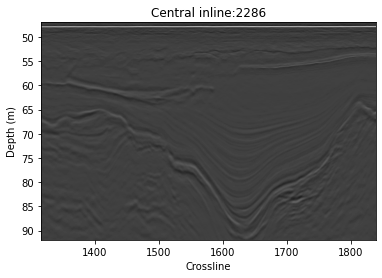

In [8]:
extent = [xlines[0], xlines[-1],depth[-1], depth[0]]
plt.imshow(data[data.shape[0]//2,:,:].T, cmap='gray',extent = extent, aspect='auto')
plt.xlabel('index number, proportional to depth')
plt.title('Central inline:' + str(f.ilines[data.shape[0]//2]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')
plt.show()

**dynamic range**  -> the range of tonal difference between the lightest light and darkest dark of an image

In our plots above we are limited by an 8-bit image representation, we can visualise 256 shades. For this to work our wide spread of amplitudes needs to be compressed into these 256 shades. However having large outliers will jeperdise having a good dynamic range

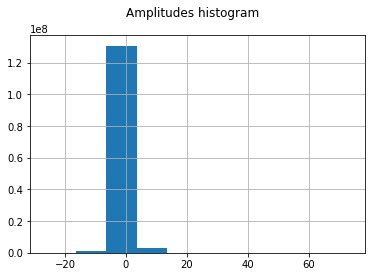

In [11]:
a = pd.Series(np.ndarray.flatten(data))
a.hist()
plt.suptitle('Amplitudes histogram')
plt.show()

To solve this we decide to clip outliers so we can use our available dynamic range better

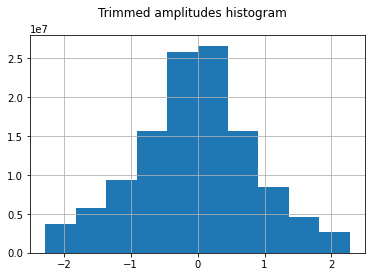

In [12]:
# Estimate the amplitude range to use for the plots by taking the 95th percentile
vm = np.percentile(data, 95)
trim = a[a.between(-vm, vm)]
trim.hist()
plt.suptitle('Trimmed amplitudes histogram')
plt.show()

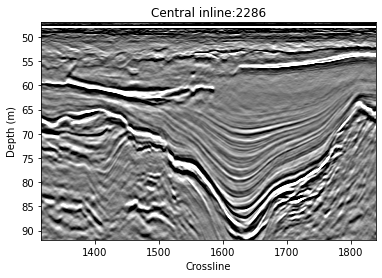

In [13]:
# Plot inline central
extent = [xlines[0], xlines[-1], depth[-1], depth[0]]
plt.imshow(data[data.shape[0]//2,:,:].T, cmap='gray', aspect='auto', extent= extent,
           vmin=-vm, vmax=vm)
plt.xlabel('index number, proportional to depth')
plt.title('Central inline:' + str(f.ilines[data.shape[0]//2]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')
plt.show()

## 3.2.2 plot inlines/crosslines/timeslices

**Question: Above you have seen examples of a central inline, repeat the same steps but show the central crossline and the central timeslice, make sure you have a good dynamic range. Further play with other colormaps, we strongly recommend trying at least the 'seismic' colour scale**

Due to our eyes biological structure we are better at seeing colour differences then grayscales

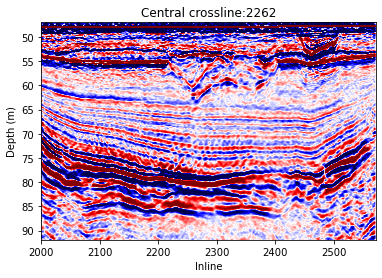

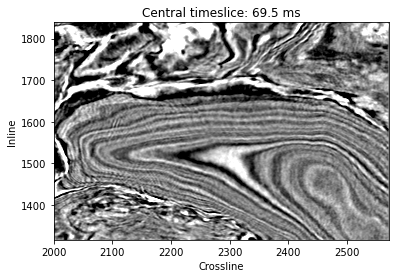

### 3.2.3 3D visualisation

The python library mayavi is a great and efficient 3D visualisation tool that we will be using to visualise our seismic data volumes. For further reading see [here](https://towardsdatascience.com/visualizing-3d-seismic-volumes-made-easy-with-python-and-mayavi-e0ca3fd61e43).

In [18]:
def explore3d(data_cube, preset = True, I=-1, X = -1 , Z=-1):
    """
    
    """
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95) #may need to play a little with the 95
    
    if preset == True:
        nx, ny, nz = data_cube.shape
        I = nx//2
        X = ny//2
        Z = nz//2

    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=I, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=X, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=Z, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.show()

## 3.3 Exploring the data volumes

In this section you will explore the data volume further for yourself. Below, we have suggested some interesting inlines (2285), xlines (1578) and depth slices (60 m) for you to look at. Do you recognise any geological features that we discussed in the lecture notes today?

In [19]:
# geological features of interest at these locations
I = np.where(inlines == 2285)[0][0]
X = np.where (xlines == 1578)[0][0]
Z = np.where (depth == 60)[0][0]
explore3d(data, preset = False, I = I, X = X, Z = Z)

[]

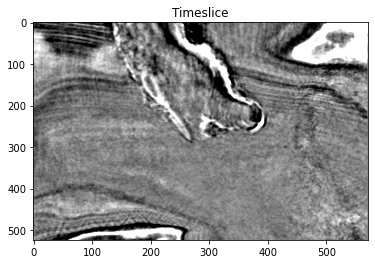

In [24]:
extent = [inlines[0], inlines[-1], xlines[0], xlines[-1]]
plt.imshow(data[:,:,Z].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)
plt.title ('Timeslice')
plt.plot()

[]

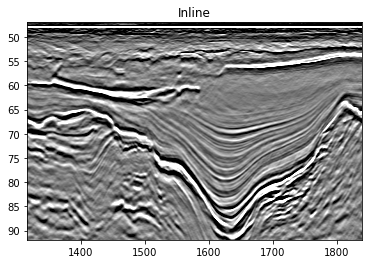

In [27]:
plt.title ('Inline')
extent = [xlines[0], xlines[-1], depth[-1], depth[0]]
plt.imshow(data[I,:,:].T, cmap='gray', extent=extent, aspect='auto', vmin=-vm, vmax=vm)
plt.plot()

[]

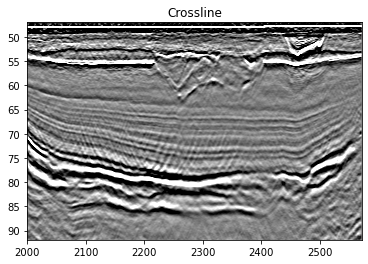

In [28]:
plt.title ('Crossline')
extent = [inlines[0], inlines[-1], depth[-1], depth[0]]
plt.imshow(data[:,X,:].T, cmap='gray', extent=extent, aspect='auto', vmin=-vm, vmax=vm)
plt.plot()

Explore the other rest of the dataset for yourself in 3D. Can you find any examples of the following geological features? If you can, give the inline/xlines numbers or depth and provide an image:

- Glacial Channel
- possible river channel
- mass transport deposit
- faults?

# 3.4 - reading in non-ideal datasets

In this section you will load the ST0202.segy dataset from the Volve field, North Sea. This dataset is not structured as nicely as TNW_small2 so you will need to do a bit more work to load it. 

- Now that our dataset is unstructure we do not have access anymore to the previously given dataset attributes, we can however work around this

- you will not be given an non-ideal dataset to process in the assessment, but we aware of the potential struggles of using non-ideal datasets if you download your own data from open source repositories. 


In [29]:
base_segy = 'data/ST0202.segy'

If you would open this segyio file assuming a perfect datacube you would run into an error!

'f = segyio.open(base_segy, ignore_geometry= False)'

So this time we do ignore the geometry

In [30]:
f = segyio.open(base_segy, ignore_geometry= True) #opens files like python default open call , assumes a well-structured 3D volume, 
print (segyio.tools.wrap(f.text[0])) #show text header to understand file better

C01 CLIENT : STATOIL                              PROCESSED BY: WESTERNGECO
C02 AREA   : VOLVE, BLOCK 15/9,  NORTH SEA - ST0202      SURVEY: 3D 4C 0BC
C03 4D POST-STACK FINAL PSDM                     DATE: 2012-03-30
C04 DATA FORMAT: SEGY       DATA TYPE: STACK-FULL ANGLE, 3-41 DEGREES (T)
C05 ---------------------AQUISITION PARAMETRS----------------------------------
C06 DATA SHOT BY VESSEL: M/V GECO ANGLER & WESTERN INLET  CABLE LENGTH:6100 M
C07 NO OF GROUPS: 960/P,X,Y,Z.  NO OF CABLES: 2  ARRAY VOL/SOURCE: 2250 CU IN.
C08 GROUP INTERVAL: 25M     SHOT INTERVAL: 25M (FLIP-FLOP)
C09 GEODECTIC DATUM:  ED50      SPHEROID: INTERNAT 1924.     PROJECTION: UTM
C10 UTM ZONE: 31 N
C11 RECORD LENGTH: 10000 MS     SAMPLE INTERVAL: 2 MS
C12 NAVIGATION SOURCE P1/90 UKOOA, SPS
C13 ----------------------PROCESSING SEQUENCE----------------------------------
C14 REFORMAT, RESAMPLING TO 4MS, NAV/SEISMIC DATA MERGE
C15 Z TO P AMP. MATCH & DESIGNATURE,TIDAL STATIC CORRECTION, NOISE ATTENUATION
C16 PZ CA

Now that our dataset is unstructured we do not have access anymore to the previously automatically given dataset attributes, we can however work around this and fix our dataset

In [32]:
inlines = []
crosslines = []
for h in f.header:
    inlines.append(h[segyio.su.iline])
    crosslines.append(h[segyio.su.xline])

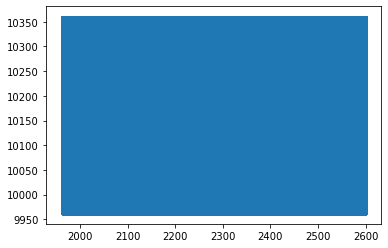

In [33]:
# Plot the inline and crossline as a scatter plot
plt.scatter(crosslines, inlines, marker="s", s=1)

If you look very closely you can see there are travces missing in the left bottom and right bottom corner! 

Lets try to understand what is missing

In [34]:
uniqil = set(inlines)
uniqxl = set(crosslines)
real = set(zip(inlines, crosslines)) #set removes duplicates, works same as sets from maths
grid = set(itertools.product(uniqil, uniqxl))
missing = grid - real
print (missing)

{(10352, 1961), (10347, 1961), (9961, 1962), (10273, 1961), (9961, 2598), (10360, 1961), (10355, 1961), (10340, 1961), (9962, 1962), (10335, 1961), (9961, 1961), (10359, 1961), (9961, 2600), (9962, 2598), (10332, 1961), (10344, 1961), (10339, 1961), (10348, 1961), (10343, 1961), (9962, 2600), (10274, 1961), (10356, 1961), (10351, 1961), (10336, 1961), (10331, 1961), (9962, 1961)}


Lets fill out the missing traces and create a regular volume. 

In [37]:
#plt.plot(inlines)
#plt.show()
#plt.plot(crosslines[:5000])
#plt.show()

# find the interval of inlines and crosslines
ils = np.unique(inlines)
xls = np.unique(crosslines)
inline_interval    = ils[1:] - ils[:-1]
crossline_interval = xls[1:] - xls[:-1]

# print(inline_interval)
# print(crossline_interval)

This file is obviously all regular and with a neat delta 1. Here you might need to make some choices should the interval be very irregular, but for this file we are good.

We now need to put every trace in the right place, which means we need to map in/crossline pairs to the right offset in our target array. Had no traces been missing, this is what segyio figures out by default.

In [38]:
ils = sorted(uniqil)
xls = sorted(uniqxl)
lineindex = {
    (il, xl): i
    for i, (il, xl) in enumerate(sorted(grid))

}

d = np.zeros((len(ils), len(xls), len(f.samples)))
lineard = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
for il, xl, trace in zip(inlines, crosslines, f.trace[:]):
    lineard[lineindex[il, xl]][:] = trace[:]

In [39]:
explore3d(d)

## EXTENSION questions if you have time- this code content here will not appear in the assessment

## 3.5 Data aliasing

The real world is continuous, however our hardware is limited in memory, time and accuracy so we need to compromise by discretising the world around. This is done through recording the signal at a constant time interval. In turn this data is then used to reconstruct the signal on a computer. 

The Nyquist theorem states that in order to to adequately reproduce a signal it should be periodically sampled at a rate that is 2x the highest frequency you wish to record. This is important when setting up an acquisition, because if you try to recover frequencies (resolutions) that do not satisfy the Nyquist theorem you will recover a wrong signal and have wrong data.

Lets write some code to visualise this:

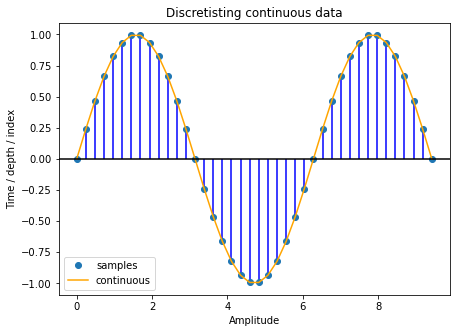

In [2]:
# data
data = np.linspace(0, 3*np.pi, 40)
sin = np.sin(data)
plt.plot(data, sin, 'o', label = 'samples')
plt.plot(data, sin, '-', label='continuous', color ='orange')

# vertical lines
sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin
plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')

# horizontal axis
plt.axhline(y=0, color='k')

plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

We can appreciate that we have plenty of data to be able to fit a correct curve to reproduce our original periodic signal. If this is the smallest frequency we are interested in being able to recover, we are wasting a lot of memory by sampling at a rate this high. If we are aware of the minimal frequency we want to be able to recover we can save on memory in the field by having the correct sampling rate.

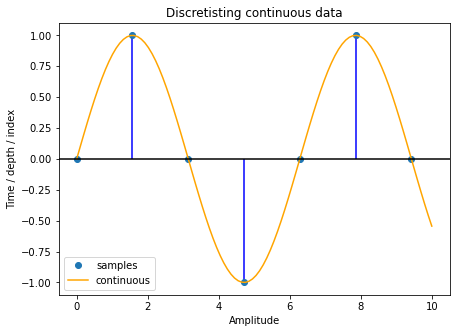

In [3]:
data = np.linspace(0, 3*np.pi, 7)
fill = np.linspace(0, 10, 100)
sin = np.sin(data)
sin_ = np.sin(fill)
plt.plot(data, sin, 'o', label = 'samples')
plt.plot(fill, sin_, '-',  label = 'continuous', color ='orange')

sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin

plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')
plt.axhline(y=0, color='k')
plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

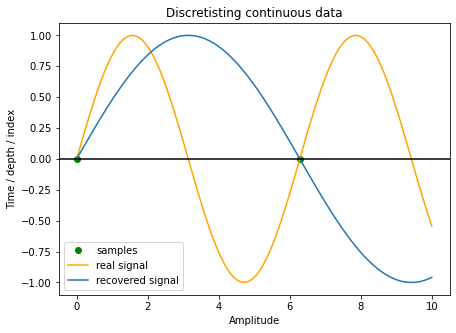

In [4]:
data = np.linspace(0, 2*np.pi, 2)
fill = np.linspace(0, 10, 100)
sin = np.sin(data)
sin_ = np.sin(fill)
sin_2 = np.sin(1/2*fill)
plt.plot(data, sin, 'o', label = 'samples',color = 'green')
plt.plot(fill, sin_, '-' , label = 'real signal', color ='orange')
plt.plot(fill, sin_2, '-', label = 'recovered signal')

sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin
plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')
plt.axhline(y=0, color='k')

plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

However if we don't plan our survey well and our sampling rate is too low we will be limited by the lowest frequency we can recover. If you do try and fit a higher frequency then determined by the nyquist frequency you might be introducing errors due to a lack of data to be able to fit the wave correctly. 

Final note of interest, in the field the receivers cut out any higher frequencies from being recorded at all, otherwise higher frequencies would be recorded as well under the lower sampling rate, distorting our data of interest.

### 3.6 EXTENSION QUESTION: Visualise the data across a diagonal transect**

3D seismic data volumes are grids of samples- therefore, we don't just have to view them along inlines, xlines or time/depth slices. We can slice through the data volume in other ways to view it. Here, we show a diaganol transect across the dataset.

In [ ]:
base_segy = 'data/TNW_small2'
data = segyio.tools.cube(base_segy)

## Feedback

Please submit any exercices and questions you have struggled with using mentimeter and we can take some time at the end of the session to review these:We will take 20 minutes at the end of the class to cover any major questions or problems that have come up. You are encouraged to to ask the GTAs and lecturers during the class, however you can always post them on here as well:

## References

- https://microscopy.berkeley.edu/courses/dib/sections/02images/sampling.html
- https://github.com/lijunzh/wiggle
